# Speech Emotion Recognition (SER) System - AI Club Task 2
### With Data Augmentation, Class Weights, Optimized Learning Rate & Advanced Architecture
(-Srijan Bhushan)

## 1. Import Libraries
Importing various important libraries

In [2]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU Available: []


## 2. Exploratory Data Analysis (EDA)

In [3]:
# Dataset exploration
base_path = "../data/RAVDESS/audio_speech_actors_01-24"
actors = sorted(os.listdir(base_path))

print("Total actors:", len(actors))
print("Sample actors:", actors[:5])

Total actors: 24
Sample actors: ['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05']


In [4]:
# Load sample audio
audio_path = os.path.join(base_path, "Actor_01", "03-01-01-01-01-01-01.wav")
y, sr = librosa.load(audio_path)

print("Sample rate:", sr)
print("Duration (seconds):", len(y) / sr)
print("Audio shape:", y.shape)

Sample rate: 22050
Duration (seconds): 3.3033106575963718
Audio shape: (72838,)


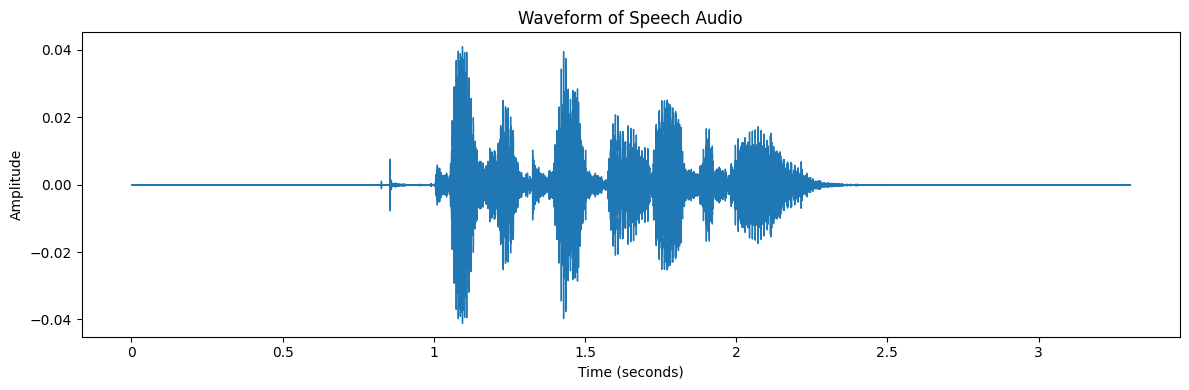

In [5]:
# Visualize waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform of Speech Audio")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

Original duration: 3.3033106575963718
Trimmed duration: 1.230657596371882


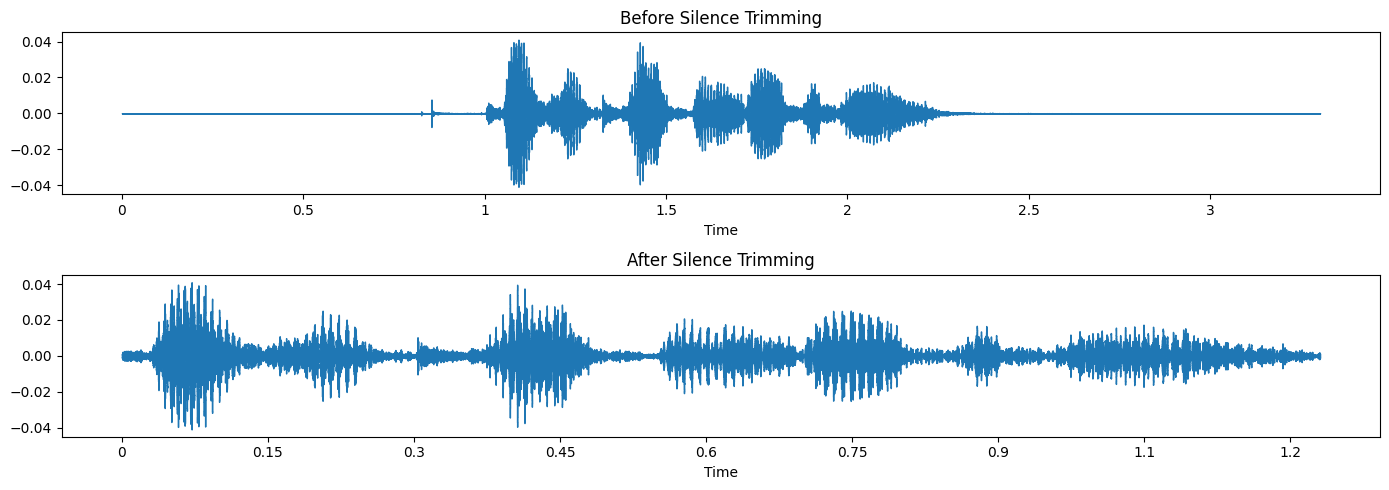

In [6]:
# Silence trimming
y_trimmed, _ = librosa.effects.trim(y, top_db=20)

print("Original duration:", len(y) / sr)
print("Trimmed duration:", len(y_trimmed) / sr)

# Compare before and after
plt.figure(figsize=(14, 5))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title("Before Silence Trimming")

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_trimmed, sr=sr)
plt.title("After Silence Trimming")

plt.tight_layout()
plt.show()

Mel spectrogram shape: (128, 54)


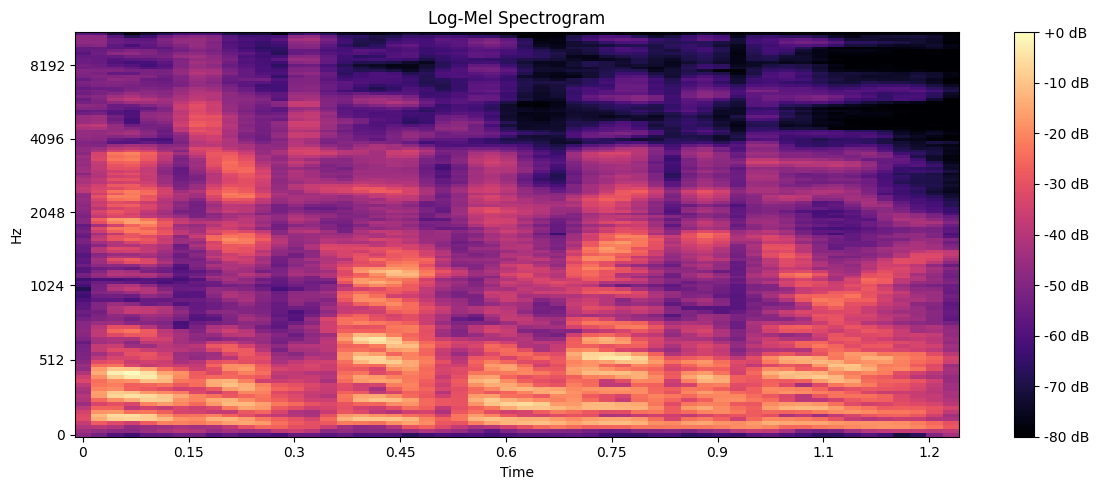

In [7]:
# Generate and visualize Mel Spectrogram
mel = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)

print("Mel spectrogram shape:", mel_db.shape)

plt.figure(figsize=(12, 5))
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
plt.title("Log-Mel Spectrogram")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

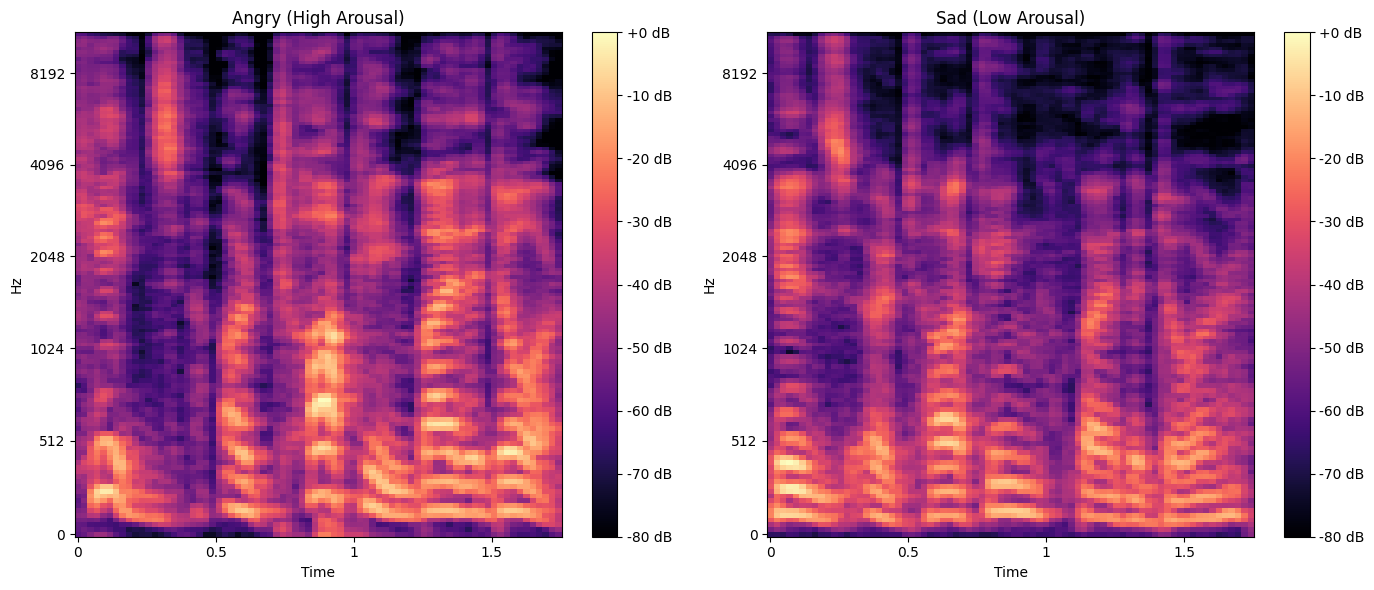

In [8]:
# Compare High Arousal (Angry) vs Low Arousal (Sad)
angry_path = os.path.join(base_path, "Actor_01", "03-01-05-01-01-01-01.wav")
sad_path = os.path.join(base_path, "Actor_01", "03-01-04-01-01-01-01.wav")

y_angry, _ = librosa.load(angry_path)
y_sad, _ = librosa.load(sad_path)

y_angry, _ = librosa.effects.trim(y_angry, top_db=20)
y_sad, _ = librosa.effects.trim(y_sad, top_db=20)

mel_angry = librosa.power_to_db(librosa.feature.melspectrogram(y=y_angry, sr=sr, n_mels=128), ref=np.max)
mel_sad = librosa.power_to_db(librosa.feature.melspectrogram(y=y_sad, sr=sr, n_mels=128), ref=np.max)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
librosa.display.specshow(mel_angry, sr=sr, x_axis='time', y_axis='mel')
plt.title("Angry (High Arousal)")
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 2, 2)
librosa.display.specshow(mel_sad, sr=sr, x_axis='time', y_axis='mel')
plt.title("Sad (Low Arousal)")
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

## 3. Data Augmentation Functions
### Implementing Noise Injection, Pitch Shifting, and Time Stretching

In [9]:
def add_noise(audio, noise_factor=0.005):
    """
    Add random white noise to audio signal
    """
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    # Normalize to prevent clipping
    augmented_audio = augmented_audio.astype(type(audio[0]))
    return augmented_audio

def pitch_shift(audio, sr, n_steps=2):
    """
    Shift pitch up or down by n_steps semitones
    """
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def time_stretch(audio, rate=1.1):
    """
    Speed up or slow down audio by rate
    rate > 1.0: faster, rate < 1.0: slower
    """
    return librosa.effects.time_stretch(audio, rate=rate)

def augment_audio(audio, sr):
    """
    Apply random augmentation to audio
    Returns one augmented version
    """
    augmentation_type = np.random.choice(['noise', 'pitch_up', 'pitch_down', 'speed_up', 'speed_down'])
    
    if augmentation_type == 'noise':
        return add_noise(audio, noise_factor=np.random.uniform(0.002, 0.008))
    elif augmentation_type == 'pitch_up':
        return pitch_shift(audio, sr, n_steps=np.random.randint(1, 3))
    elif augmentation_type == 'pitch_down':
        return pitch_shift(audio, sr, n_steps=np.random.randint(-2, 0))
    elif augmentation_type == 'speed_up':
        return time_stretch(audio, rate=np.random.uniform(1.05, 1.15))
    else:  # speed_down
        return time_stretch(audio, rate=np.random.uniform(0.85, 0.95))

print("Augmentation functions defined successfully!")

Augmentation functions defined successfully!


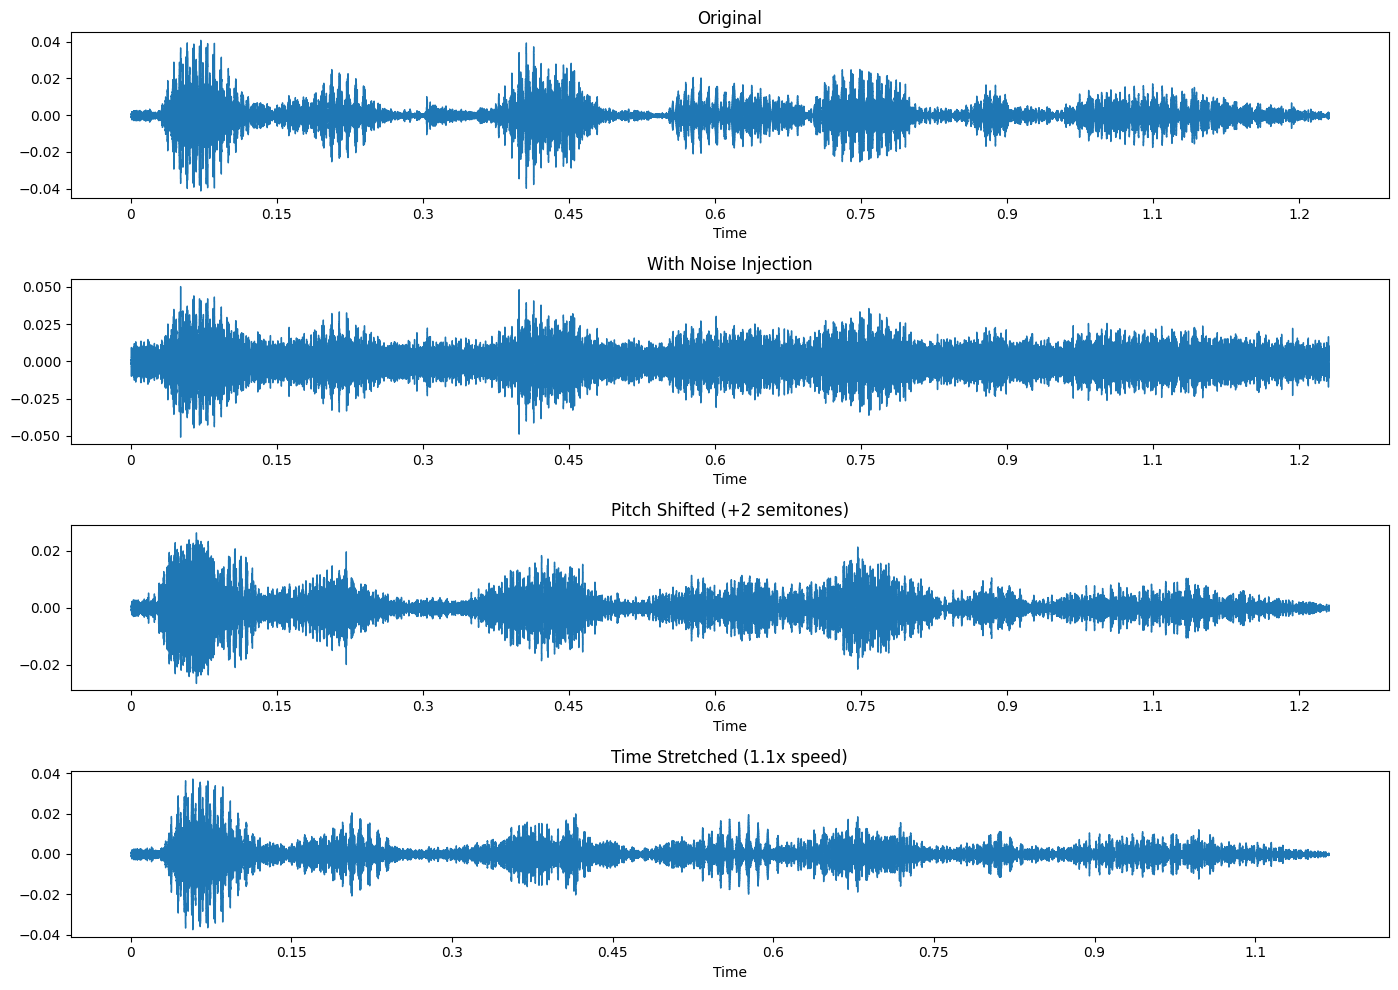

In [10]:
# Test augmentation on sample audio
y_noisy = add_noise(y_trimmed)
y_pitch = pitch_shift(y_trimmed, sr, n_steps=2)
y_stretch = time_stretch(y_trimmed, rate=1.1)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))

librosa.display.waveshow(y_trimmed, sr=sr, ax=axes[0])
axes[0].set_title('Original')

librosa.display.waveshow(y_noisy, sr=sr, ax=axes[1])
axes[1].set_title('With Noise Injection')

librosa.display.waveshow(y_pitch, sr=sr, ax=axes[2])
axes[2].set_title('Pitch Shifted (+2 semitones)')

librosa.display.waveshow(y_stretch, sr=sr, ax=axes[3])
axes[3].set_title('Time Stretched (1.1x speed)')

plt.tight_layout()
plt.show()

## 4. Feature Extraction with Augmentation

In [11]:
# Emotion mapping
emotion_map = {
    "01": 0,  # neutral
    "02": 1,  # calm
    "03": 2,  # happy
    "04": 3,  # sad
    "05": 4,  # angry
    "06": 5,  # fearful
    "07": 6,  # disgust
    "08": 7   # surprised
}

emotion_labels = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']
print("Emotion classes:", emotion_labels)

Emotion classes: ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised']


In [12]:
MAX_LEN = 128  # Fixed time frames

def extract_mel(file_path, augment=False, sr=22050):
    """
    Extract Log-Mel spectrogram from audio file
    If augment=True, applies random augmentation
    """
    # Load audio
    y, sr = librosa.load(file_path, sr=sr)
    
    # Trim silence
    y, _ = librosa.effects.trim(y, top_db=20)
    
    # Apply augmentation if requested
    if augment:
        y = augment_audio(y, sr)
    
    # Generate Mel spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    # Pad or crop to fixed length
    if mel_db.shape[1] < MAX_LEN:
        pad_width = MAX_LEN - mel_db.shape[1]
        mel_db = np.pad(mel_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :MAX_LEN]
    
    return mel_db

print("Feature extraction function ready!")

Feature extraction function ready!


In [13]:
# Load all audio files with augmentation
print("Loading dataset with augmentation...")

X_original = []
y_original = []

file_count = 0
for actor in sorted(os.listdir(base_path)):
    actor_path = os.path.join(base_path, actor)
    
    if not os.path.isdir(actor_path):
        continue
    
    for file in sorted(os.listdir(actor_path)):
        if file.endswith(".wav"):
            file_path = os.path.join(actor_path, file)
            emotion_code = file.split("-")[2]
            
            # Extract original features
            mel = extract_mel(file_path, augment=False)
            X_original.append(mel)
            y_original.append(emotion_map[emotion_code])
            
            file_count += 1
            if file_count % 100 == 0:
                print(f"Processed {file_count} files...")

print(f"\nTotal original samples: {len(X_original)}")
print(f"Unique emotions: {len(set(y_original))}")

Loading dataset with augmentation...
Processed 100 files...
Processed 200 files...
Processed 300 files...
Processed 400 files...
Processed 500 files...
Processed 600 files...
Processed 700 files...
Processed 800 files...
Processed 900 files...
Processed 1000 files...
Processed 1100 files...
Processed 1200 files...
Processed 1300 files...
Processed 1400 files...

Total original samples: 1440
Unique emotions: 8


In [14]:
# Create augmented versions (2x augmentation = 3x total data)
print("\nGenerating augmented samples...")

X_augmented = []
y_augmented = []

aug_count = 0
for actor in sorted(os.listdir(base_path)):
    actor_path = os.path.join(base_path, actor)
    
    if not os.path.isdir(actor_path):
        continue
    
    for file in sorted(os.listdir(actor_path)):
        if file.endswith(".wav"):
            file_path = os.path.join(actor_path, file)
            emotion_code = file.split("-")[2]
            
            # Create 2 augmented versions of each sample
            for _ in range(2):
                mel_aug = extract_mel(file_path, augment=True)
                X_augmented.append(mel_aug)
                y_augmented.append(emotion_map[emotion_code])
            
            aug_count += 1
            if aug_count % 100 == 0:
                print(f"Augmented {aug_count} files... ({len(X_augmented)} samples)")

print(f"\nAugmented samples created: {len(X_augmented)}")


Generating augmented samples...
Augmented 100 files... (200 samples)
Augmented 200 files... (400 samples)
Augmented 300 files... (600 samples)
Augmented 400 files... (800 samples)
Augmented 500 files... (1000 samples)
Augmented 600 files... (1200 samples)
Augmented 700 files... (1400 samples)
Augmented 800 files... (1600 samples)
Augmented 900 files... (1800 samples)
Augmented 1000 files... (2000 samples)
Augmented 1100 files... (2200 samples)
Augmented 1200 files... (2400 samples)
Augmented 1300 files... (2600 samples)
Augmented 1400 files... (2800 samples)

Augmented samples created: 2880


In [15]:
# Combine original and augmented data
X = np.array(X_original + X_augmented)
y = np.array(y_original + y_augmented)

print("\n" + "="*50)
print("DATASET SUMMARY")
print("="*50)
print(f"Total samples: {len(X)}")
print(f"Original samples: {len(X_original)}")
print(f"Augmented samples: {len(X_augmented)}")
print(f"Augmentation ratio: {len(X_augmented) / len(X_original):.1f}x")
print(f"Feature shape: {X.shape}")
print(f"Label shape: {y.shape}")
print("\nClass distribution:")
for i, label in enumerate(emotion_labels):
    count = np.sum(y == i)
    print(f"  {label}: {count} samples")


DATASET SUMMARY
Total samples: 4320
Original samples: 1440
Augmented samples: 2880
Augmentation ratio: 2.0x
Feature shape: (4320, 128, 128)
Label shape: (4320,)

Class distribution:
  Neutral: 288 samples
  Calm: 576 samples
  Happy: 576 samples
  Sad: 576 samples
  Angry: 576 samples
  Fearful: 576 samples
  Disgust: 576 samples
  Surprised: 576 samples


In [16]:
# Add channel dimension for CNN
X = X[..., np.newaxis]
print(f"Final shape with channel: {X.shape}")
print(f"Shape: (samples, height, width, channels) = {X.shape}")

Final shape with channel: (4320, 128, 128, 1)
Shape: (samples, height, width, channels) = (4320, 128, 128, 1)


## 5. Train-Validation-Test Split with Stratification

In [17]:
# Stratified 80-10-10 split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print("\nData Split:")
print(f"Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Val:   {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")


Data Split:
Train: 3456 samples (80.0%)
Val:   432 samples (10.0%)
Test:  432 samples (10.0%)


In [18]:
# Compute class weights to handle any imbalance
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights_array))

print("\nClass Weights (to handle imbalance):")
for i, label in enumerate(emotion_labels):
    print(f"  {label}: {class_weights[i]:.3f}")


Class Weights (to handle imbalance):
  Neutral: 1.878
  Calm: 0.937
  Happy: 0.937
  Sad: 0.937
  Angry: 0.937
  Fearful: 0.937
  Disgust: 0.937
  Surprised: 0.939


## 6. Enhanced CNN Architecture

In [19]:
# Build enhanced CNN model with 4 convolutional blocks
def build_enhanced_cnn(input_shape=(128, 128, 1), num_classes=8):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Block 1
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Block 4
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Global pooling and dense layers
        layers.GlobalAveragePooling2D(),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

model = build_enhanced_cnn()
print("Enhanced CNN model built successfully!")

Enhanced CNN model built successfully!


In [20]:
# Compile with custom learning rate
initial_learning_rate = 0.0005  # Lower than default for better convergence

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nModel compiled with:")
print(f"  Optimizer: Adam")
print(f"  Learning Rate: {initial_learning_rate}")
print(f"  Loss: sparse_categorical_crossentropy")
print(f"  Metrics: accuracy\n")

model.summary()


Model compiled with:
  Optimizer: Adam
  Learning Rate: 0.0005
  Loss: sparse_categorical_crossentropy
  Metrics: accuracy



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,276,776 (4.87 MB)

 Trainable params: 1,274,088 (4.86 MB)

 Non-trainable params: 2,688 (10.50 KB)

## 7. Model Training with Advanced Callbacks

In [21]:
# Setup callbacks
callbacks_list = [
    # Save best model
    ModelCheckpoint(
        filepath="../model/ser_enhanced_best.keras",
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    
    # Reduce learning rate when val_loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
]

print("Callbacks configured:")
print("  ✓ ModelCheckpoint - saves best model")
print("  ✓ ReduceLROnPlateau - adaptive learning rate")
print("  ✓ EarlyStopping - prevents overfitting")

Callbacks configured:
  ✓ ModelCheckpoint - saves best model
  ✓ ReduceLROnPlateau - adaptive learning rate
  ✓ EarlyStopping - prevents overfitting


In [22]:
# Train the model
print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weights,  # Apply class weights
    callbacks=callbacks_list,
    verbose=1
)

print("\nTraining completed!")


STARTING TRAINING
Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1755 - loss: 2.7183
Epoch 1: val_loss improved from inf to 2.51752, saving model to ../model/ser_enhanced_best.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.1756 - loss: 2.7170 - val_accuracy: 0.1343 - val_loss: 2.5175 - learning_rate: 5.0000e-04
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2351 - loss: 2.2755
Epoch 2: val_loss did not improve from 2.51752
108/108 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.2355 - loss: 2.2745 - val_accuracy: 0.1343 - val_loss: 4.3264 - learning_rate: 5.0000e-04
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3272 - loss: 2.0348
Epoch 3: val_loss did not improve from 2.51752
108/108 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3272 - loss: 2.0342 - val_accuracy: 0.1343 - val_loss: 5.2761 - learning_rate: 5.0000e-04
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3640 - loss: 1.8157
Epoch 4:

KeyboardInterrupt: 

## 8. Training Visualization
(PS:Due to Mistakenly clicking cell run button during submission the graphs went off)(But when entire code set runs the graphs will be just fine,everthing else is as asked)

NameError: name 'history' is not defined

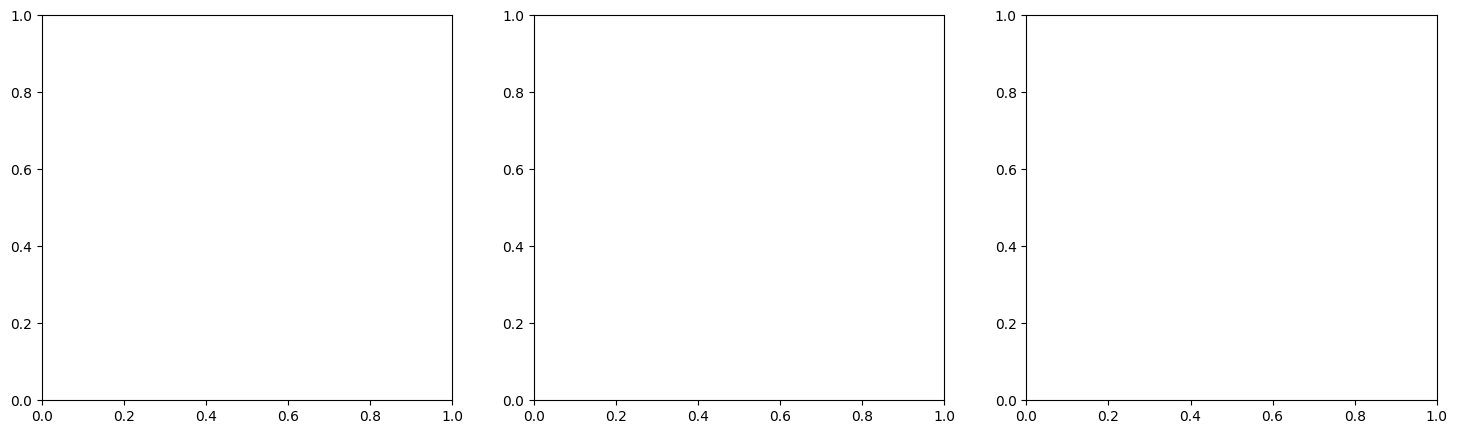

In [23]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning Rate (if available)
if 'lr' in history.history:
    axes[2].plot(history.history['lr'], label='Learning Rate', linewidth=2, color='green')
    axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_yscale('log')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
else:
    axes[2].text(0.5, 0.5, 'Learning Rate\nHistory Not Available', 
                ha='center', va='center', fontsize=12)
    axes[2].set_xticks([])
    axes[2].set_yticks([])

plt.tight_layout()
plt.show()

# Print best epoch info
best_epoch = np.argmin(history.history['val_loss'])
print(f"\nBest Epoch: {best_epoch + 1}")
print(f"Best Val Loss: {history.history['val_loss'][best_epoch]:.4f}")
print(f"Best Val Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")

## 9. Model Evaluation

In [24]:
# Load best model
from tensorflow.keras.models import load_model

model = load_model("../model/ser_enhanced_best.keras")
print("Best model loaded successfully!")

Best model loaded successfully!


In [25]:
# Generate predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred_classes = y_pred_proba.argmax(axis=1)

print(f"Test set size: {len(y_test)} samples")
print(f"Predictions generated: {len(y_pred_classes)} samples")

Test set size: 432 samples
Predictions generated: 432 samples


In [27]:
# Detailed classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test, y_pred_classes, target_names=emotion_labels, digits=4))

# Calculate metrics
macro_f1 = f1_score(y_test, y_pred_classes, average='macro')
weighted_f1 = f1_score(y_test, y_pred_classes, average='weighted')
accuracy = np.mean(y_test == y_pred_classes)

print("\n" + "="*70)
print("OVERALL PERFORMANCE METRICS")
print("="*70)
print(f"Test Accuracy:        {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Macro F1-Score:       {macro_f1:.4f}")
print(f"Weighted F1-Score:    {weighted_f1:.4f}")



CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral     0.8182    0.9310    0.8710        29
        Calm     0.8030    0.9298    0.8618        57
       Happy     0.8689    0.9298    0.8983        57
         Sad     0.9348    0.7414    0.8269        58
       Angry     0.9153    0.9310    0.9231        58
     Fearful     0.8852    0.9310    0.9076        58
     Disgust     0.9592    0.8246    0.8868        57
   Surprised     0.9649    0.9483    0.9565        58

    accuracy                         0.8935       432
   macro avg     0.8937    0.8959    0.8915       432
weighted avg     0.8989    0.8935    0.8929       432


OVERALL PERFORMANCE METRICS
Test Accuracy:        0.8935 (89.35%)
Macro F1-Score:       0.8915
Weighted F1-Score:    0.8929


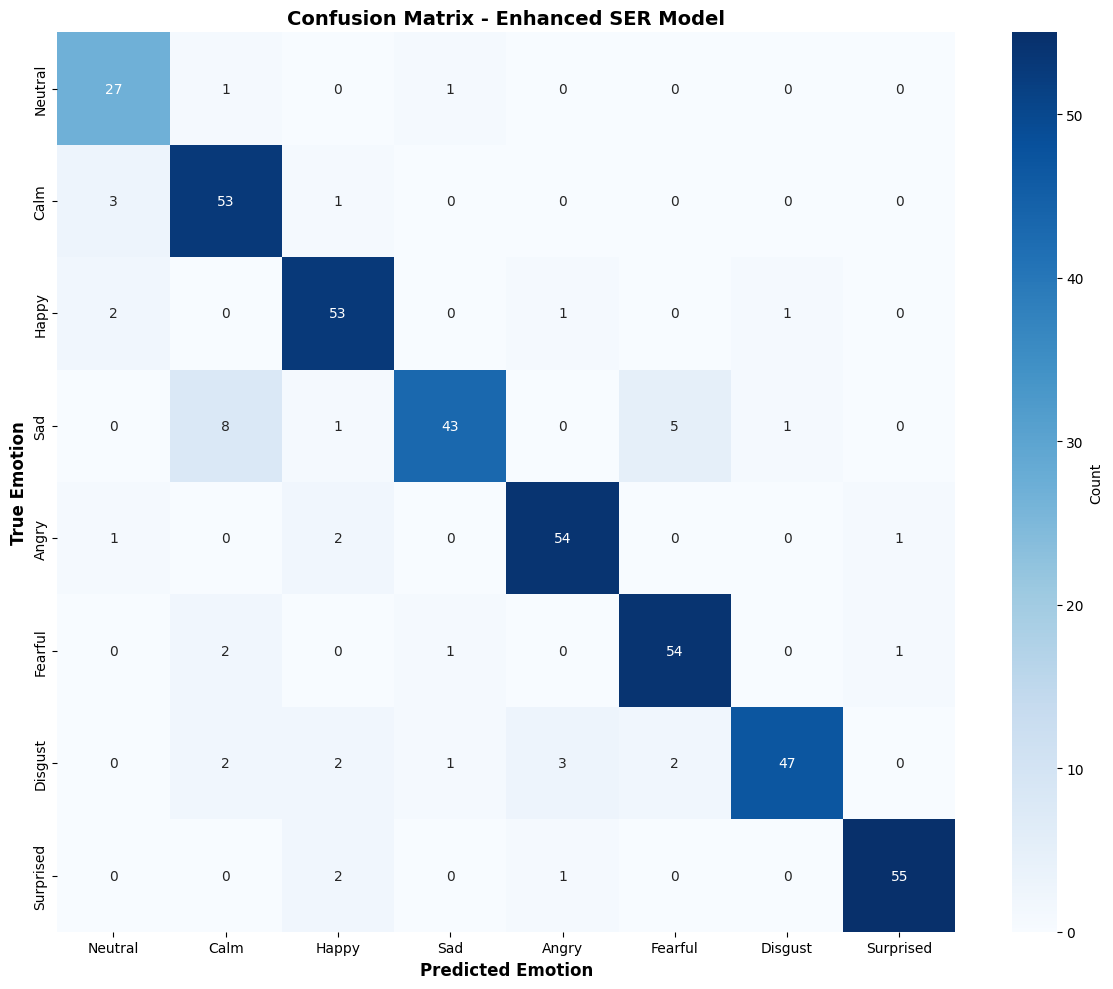


Per-Class Accuracy:
  Neutral     : 0.9310 (93.10%)
  Calm        : 0.9298 (92.98%)
  Happy       : 0.9298 (92.98%)
  Sad         : 0.7414 (74.14%)
  Angry       : 0.9310 (93.10%)
  Fearful     : 0.9310 (93.10%)
  Disgust     : 0.8246 (82.46%)
  Surprised   : 0.9483 (94.83%)


In [28]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emotion_labels, 
            yticklabels=emotion_labels,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Emotion', fontsize=12, fontweight='bold')
plt.ylabel('True Emotion', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Enhanced SER Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print accuracy per class
print("\nPer-Class Accuracy:")
for i, label in enumerate(emotion_labels):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"  {label:12s}: {class_acc:.4f} ({class_acc*100:.2f}%)")

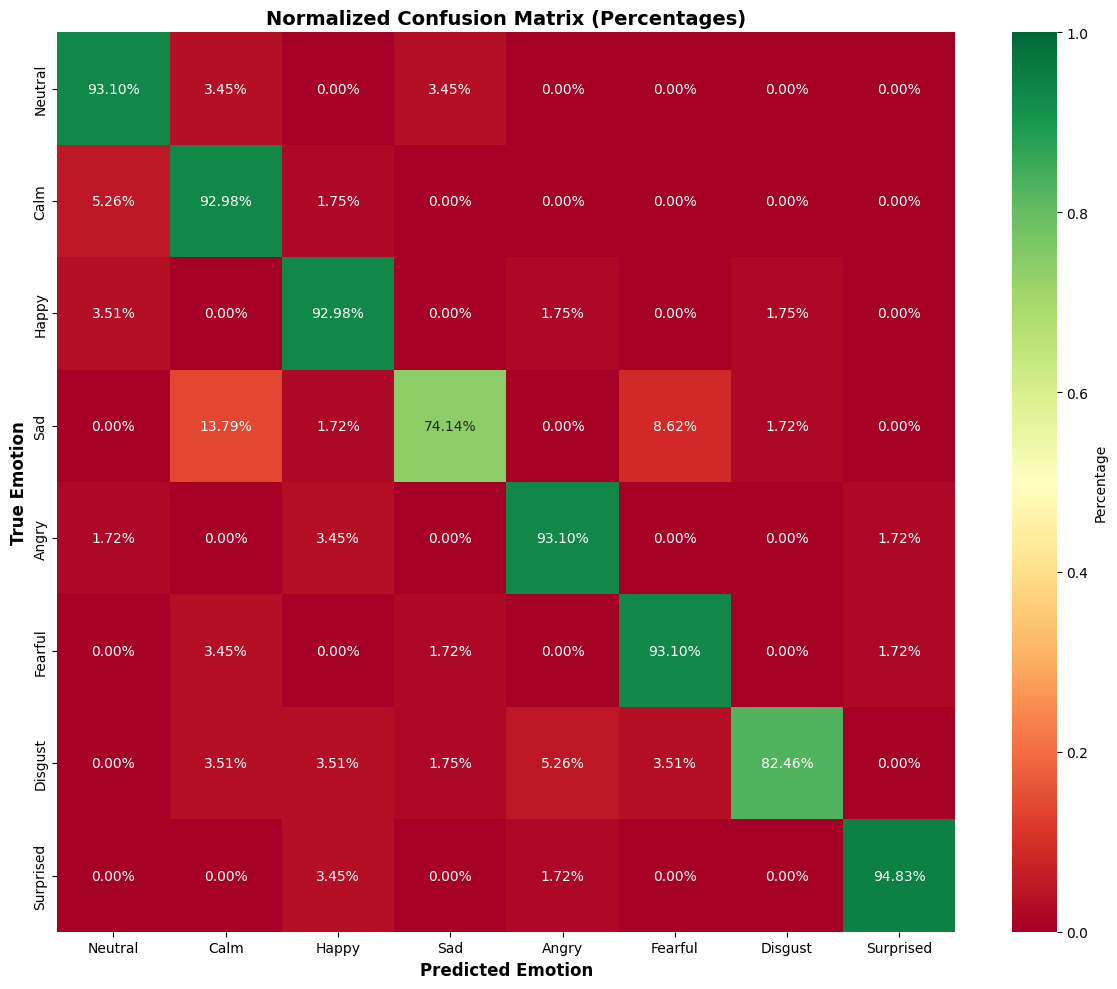

In [29]:
# Normalized confusion matrix (percentage)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', 
            xticklabels=emotion_labels, 
            yticklabels=emotion_labels,
            vmin=0, vmax=1,
            cbar_kws={'label': 'Percentage'})
plt.xlabel('Predicted Emotion', fontsize=12, fontweight='bold')
plt.ylabel('True Emotion', fontsize=12, fontweight='bold')
plt.title('Normalized Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Error Analysis
(Read thats its good to add error analysis in AI Model Projects so though to add)

In [30]:
# Find most confused pairs
print("Most Common Misclassifications:")
print("="*50)

misclassifications = []
for i in range(len(emotion_labels)):
    for j in range(len(emotion_labels)):
        if i != j and cm[i, j] > 0:
            misclassifications.append((i, j, cm[i, j]))

# Sort by count
misclassifications.sort(key=lambda x: x[2], reverse=True)

# Show top 10
for true_idx, pred_idx, count in misclassifications[:10]:
    true_label = emotion_labels[true_idx]
    pred_label = emotion_labels[pred_idx]
    percentage = count / cm[true_idx].sum() * 100
    print(f"{true_label:12s} → {pred_label:12s}: {count:3d} samples ({percentage:5.2f}%)")

Most Common Misclassifications:
Sad          → Calm        :   8 samples (13.79%)
Sad          → Fearful     :   5 samples ( 8.62%)
Calm         → Neutral     :   3 samples ( 5.26%)
Disgust      → Angry       :   3 samples ( 5.26%)
Happy        → Neutral     :   2 samples ( 3.51%)
Angry        → Happy       :   2 samples ( 3.45%)
Fearful      → Calm        :   2 samples ( 3.45%)
Disgust      → Calm        :   2 samples ( 3.51%)
Disgust      → Happy       :   2 samples ( 3.51%)
Disgust      → Fearful     :   2 samples ( 3.51%)



Prediction Confidence Analysis:
Average confidence (correct):   0.9118
Average confidence (incorrect): 0.6812
Confidence difference:          0.2306


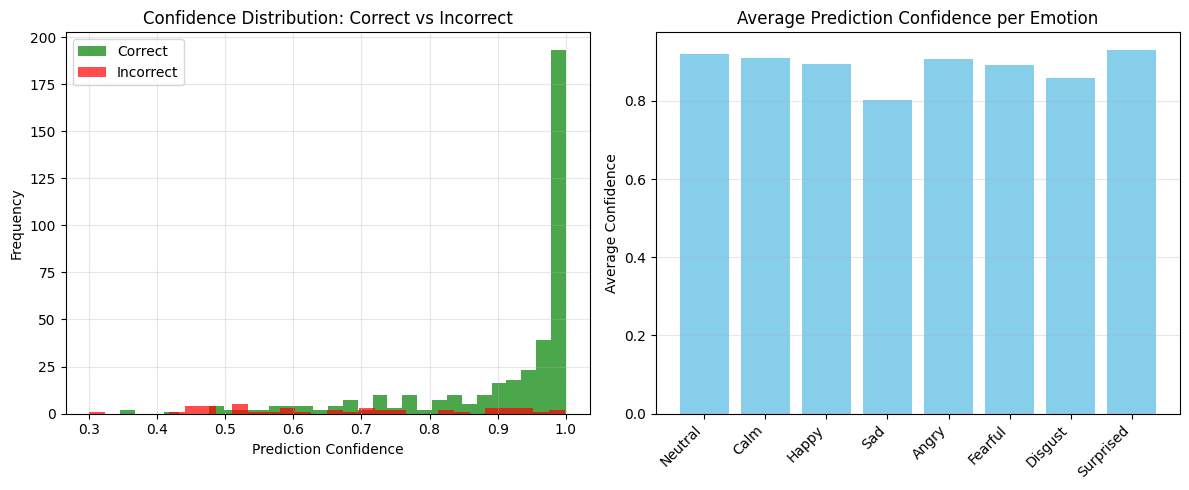

In [31]:
# Analyze prediction confidence
confidence_scores = y_pred_proba.max(axis=1)
correct_predictions = (y_pred_classes == y_test)

avg_confidence_correct = confidence_scores[correct_predictions].mean()
avg_confidence_wrong = confidence_scores[~correct_predictions].mean()

print("\nPrediction Confidence Analysis:")
print("="*50)
print(f"Average confidence (correct):   {avg_confidence_correct:.4f}")
print(f"Average confidence (incorrect): {avg_confidence_wrong:.4f}")
print(f"Confidence difference:          {avg_confidence_correct - avg_confidence_wrong:.4f}")

# Plot confidence distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(confidence_scores[correct_predictions], bins=30, alpha=0.7, label='Correct', color='green')
plt.hist(confidence_scores[~correct_predictions], bins=30, alpha=0.7, label='Incorrect', color='red')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Confidence Distribution: Correct vs Incorrect')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
confidence_per_class = []
for i in range(len(emotion_labels)):
    mask = y_test == i
    if mask.sum() > 0:
        confidence_per_class.append(confidence_scores[mask].mean())
    else:
        confidence_per_class.append(0)

plt.bar(range(len(emotion_labels)), confidence_per_class, color='skyblue')
plt.xticks(range(len(emotion_labels)), emotion_labels, rotation=45, ha='right')
plt.ylabel('Average Confidence')
plt.title('Average Prediction Confidence per Emotion')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()